## Overview

I am going to load data and clean data dataset. Then, I will add a new column 'status' which contains user adoption. After adding a new column, I am going to start EDA to look for some valid findings.


## 1. load data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
import math
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from lightgbm import LGBMClassifier
import time
import json


In [2]:
# load excel
user_engagement = pd.read_csv("takehome_user_engagement.csv")
#user_engagement = pd.read_csv("takehome_users.csv")

In [3]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
users = pd.read_csv("takehome_users.csv", encoding='latin-1')

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


## 2. data cleaning

### convert type

In [6]:
user_engagement['user_id'] = user_engagement['user_id'].astype(object)
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(object)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(object)

In [7]:
# define time_stamp as new index
user_engagement = user_engagement.set_index('time_stamp')
user_engagement.index = pd.to_datetime(user_engagement.index)

### missing values

In [8]:
users['last_session_creation_time'].fillna(value = users['last_session_creation_time'].mean(),
          inplace = True)

In [9]:
users['invited_by_user_id'].fillna(value = 'NA',
          inplace = True)

In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  object 
 7   enabled_for_marketing_drip  12000 non-null  object 
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 937.6+ KB


### create new column 'status'

this column will be a dependent variable when we create a model. 

In [11]:
# sort by user_id
user_engagement = user_engagement.sort_values('user_id')

In [12]:
user_engagement.head(10)

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2014-03-31 03:45:04,2,1
2014-03-13 03:45:04,2,1
2014-03-09 03:45:04,2,1
2014-02-16 03:45:04,2,1
2014-02-13 03:45:04,2,1
2014-02-09 03:45:04,2,1
2014-02-08 03:45:04,2,1
2014-01-08 03:45:04,2,1


In [13]:
# create new df to count number of visits
user_id_count = user_engagement['user_id'].value_counts()

In [14]:
# make it dataframe
user_id_count = user_id_count.to_frame()

# reset index
user_id_count = user_id_count.reset_index()

# replace column name
user_id_count.columns = user_id_count.columns.str.replace('user_id', 'counts')
user_id_count.columns = user_id_count.columns.str.replace('index', 'user_id')


In [15]:
user_id_count

,user_id,counts
0,3623,606
1,906,600
2,1811,593
3,7590,590
4,8068,585
...,...,...
8818,4699,1
8819,4698,1
8820,4697,1
8821,4696,1


In [16]:
# define new column status and Temporarily input as Adopted
user_id_count['status'] = 'Adopted'

In [17]:
user_id_count

,user_id,counts,status
0,3623,606,Adopted
1,906,600,Adopted
2,1811,593,Adopted
3,7590,590,Adopted
4,8068,585,Adopted
...,...,...,...
8818,4699,1,Adopted
8819,4698,1,Adopted
8820,4697,1,Adopted
8821,4696,1,Adopted


**time stamp is full 2 years. I think defining adopted user should be mean value of counts, not a user who has logged into the product on three separate days in at least one seven day period**

In [18]:
user_id_count.counts.mean()

23.565340587101893

In [19]:
# if counts is less than 24, define status as "Not Adopted"
for i in range(len(user_id_count)):
    #print(i)
    if user_id_count['counts'][i] < 24:
        user_id_count['status'][i] = 'Not Adopted'



    


/var/folders/3p/j9v4cftj6bv03_rdsgtmknsr0000gn/T/ipykernel_11097/773594370.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_id_count['status'][i] = 'Not Adopted'


In [20]:
user_id_count['status'].value_counts()

Not Adopted    7666
Adopted        1157
Name: status, dtype: int64

In [21]:
user_id_count['user_id'] = user_id_count['user_id'].astype(object)
user_id_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  8823 non-null   object
 1   counts   8823 non-null   int64 
 2   status   8823 non-null   object
dtypes: int64(1), object(2)
memory usage: 206.9+ KB


### merge dataset (add status in the original dataframe)

In [22]:
user_engagement=user_engagement.merge(user_id_count[['status', 'user_id']], on = 'user_id', how = 'right')

In [23]:
user_engagement.status.value_counts()

Adopted        192432
Not Adopted     15485
Name: status, dtype: int64

In [24]:
user_id_count[(user_id_count.user_id == 2400)]

,user_id,counts,status
1157,2400,23,Not Adopted


In [25]:
user_engagement[(user_engagement.status == "Not Adopted")]

,user_id,visited,status
192432,2400,1,Not Adopted
192433,2400,1,Not Adopted
192434,2400,1,Not Adopted
192435,2400,1,Not Adopted
192436,2400,1,Not Adopted
...,...,...,...
207912,4699,1,Not Adopted
207913,4698,1,Not Adopted
207914,4697,1,Not Adopted
207915,4696,1,Not Adopted


In [26]:
del user_engagement['visited']
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  207917 non-null  object
 1   status   207917 non-null  object
dtypes: object(2)
memory usage: 4.8+ MB


In [27]:
len(pd.unique(user_engagement['user_id']))

8823

In [28]:
user_engagement=user_engagement.drop_duplicates()

In [29]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  8823 non-null   object
 1   status   8823 non-null   object
dtypes: object(2)
memory usage: 206.8+ KB


### merge dataset user_engagement and users

In [30]:
users.describe()

,object_id,last_session_creation_time,org_id
count,12000.00000,1.200000e+04,12000.000000
mean,6000.50000,1.379279e+09,141.884583
std,3464.24595,1.674708e+07,124.056723
min,1.00000,1.338452e+09,0.000000
25%,3000.75000,1.370563e+09,29.000000
50%,6000.50000,1.379279e+09,108.000000
75%,9000.25000,1.393729e+09,238.250000
max,12000.00000,1.402067e+09,416.000000


In [31]:
# match column name -- object_id => user_id
users.columns = users.columns.str.replace('object_id', 'user_id')
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [32]:
user_engagement['status'].value_counts()

Not Adopted    7666
Adopted        1157
Name: status, dtype: int64

In [85]:
# merge
new_users=users.merge(user_engagement[['status', 'user_id']], on = 'user_id', how = 'left')

In [86]:
new_users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,status
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,Not Adopted
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,Not Adopted
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,Not Adopted
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,Not Adopted
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,Not Adopted


In [87]:
new_users['status'].value_counts()

Not Adopted    7666
Adopted        1157
Name: status, dtype: int64

In [88]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  object 
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  object 
 7   enabled_for_marketing_drip  12000 non-null  object 
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  object 
 10  status                      8823 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB


### treat missing values for new dataframe

In [89]:
new_users['status'].fillna(value = 'NA',
          inplace = True)
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  object 
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  object 
 7   enabled_for_marketing_drip  12000 non-null  object 
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  object 
 10  status                      12000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB


In [38]:
new_users.status.value_counts()

Not Adopted    7666
NA             3177
Adopted        1157
Name: status, dtype: int64

In [90]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  object 
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  object 
 7   enabled_for_marketing_drip  12000 non-null  object 
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  object 
 10  status                      12000 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 1.1+ MB


### delete unnecessary columns

We have to delete below columns because those include so many unique values. Therefore, it's hard to find the patterns.

In [91]:
new_users = new_users.drop(['user_id', 'creation_time', 'name', 'email', 'org_id', 'invited_by_user_id'], axis=1)

In [41]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   last_session_creation_time  12000 non-null  float64
 2   opted_in_to_mailing_list    12000 non-null  object 
 3   enabled_for_marketing_drip  12000 non-null  object 
 4   status                      12000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 562.5+ KB


## 3. EDA

### Discrete variable

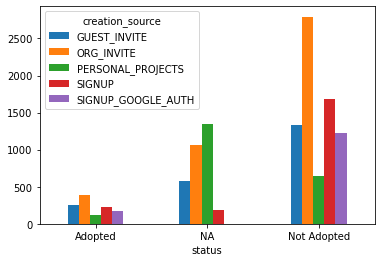

In [42]:
# Creating crosstab
crosstb = pd.crosstab(new_users.status, new_users.creation_source)
 
# Creating barplot
barplot = crosstb.plot.bar(rot=0)

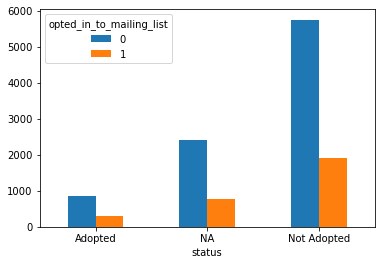

In [43]:
# Creating crosstab
crosstb = pd.crosstab(new_users.status, new_users.opted_in_to_mailing_list)
 
# Creating barplot
barplot = crosstb.plot.bar(rot=0)

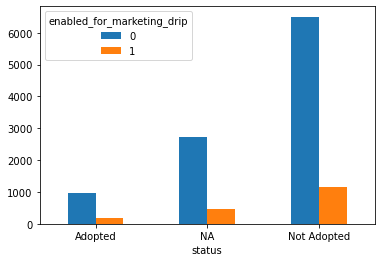

In [44]:
# Creating crosstab
crosstb = pd.crosstab(new_users.status, new_users.enabled_for_marketing_drip)
 
# Creating barplot
barplot = crosstb.plot.bar(rot=0)

### Continuos variable

<AxesSubplot:xlabel='status', ylabel='last_session_creation_time'>

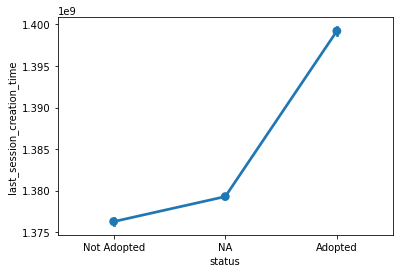

In [45]:
sns.pointplot(x='status',y='last_session_creation_time',data=new_users)


## Conclusion

It's hard to find relations between dependent and discrete independent variables (creation_source, enabled_for_marketing_drip, and opted_in_to_mailing_list). However, pointplot with contiuous variable (last_session_creation_time) shows pattern that adopted user relatively has large session creation time. If I could have full dataset of status variable, I might find out some valid outcome. There are pretty large amount of NA (around 3000). 

## 4. Preprocessing

### Dummy variables

In [92]:
# Create dummy variables.
new_users = pd.get_dummies(new_users, columns=['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip'], prefix=['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip'])

# Print the columns names
print(new_users.columns)

Index(['last_session_creation_time', 'status', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'opted_in_to_mailing_list_0', 'opted_in_to_mailing_list_1',
       'enabled_for_marketing_drip_0', 'enabled_for_marketing_drip_1'],
      dtype='object')


/Users/hansangjun/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


### Scale continuous variable

In [93]:
# collect int and float
names_list = ['last_session_creation_time']
names_list_SS = ['last_session_creation_time_SS']
scale_df = new_users[names_list]

# define scaler
scaler = StandardScaler()

# fit scale_df
scaler.fit(scale_df)

# transform the data using fitted scaler
scaled_df = scaler.transform(scale_df)

# make it dataframe
scaled_df = pd.DataFrame(scaled_df, columns=names_list_SS) 
scaled_df.head()

,last_session_creation_time_SS
0,1.126184
1,1.012649
2,-0.928225
3,-0.601272
4,-1.219944


In [94]:
# drop original int and float varaibles
new_users.drop(columns=names_list, inplace=True)

# concatenating scaled_df and df along columns
new_users = pd.concat([scaled_df, new_users], axis=1)

In [52]:
new_users.head()

,last_session_creation_time_SS,status,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_0,opted_in_to_mailing_list_1,enabled_for_marketing_drip_0,enabled_for_marketing_drip_1
0,1.126184,Not Adopted,1,0,0,0,0,0,1,1,0
1,1.012649,Not Adopted,0,1,0,0,0,1,0,1,0
2,-0.928225,Not Adopted,0,1,0,0,0,1,0,1,0
3,-0.601272,Not Adopted,1,0,0,0,0,1,0,1,0
4,-1.219944,Not Adopted,1,0,0,0,0,1,0,1,0


## 5. Model

### Split dataset and create a random forest model

In [95]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   last_session_creation_time_SS       12000 non-null  float64
 1   status                              12000 non-null  object 
 2   creation_source_GUEST_INVITE        12000 non-null  uint8  
 3   creation_source_ORG_INVITE          12000 non-null  uint8  
 4   creation_source_PERSONAL_PROJECTS   12000 non-null  uint8  
 5   creation_source_SIGNUP              12000 non-null  uint8  
 6   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  uint8  
 7   opted_in_to_mailing_list_0          12000 non-null  uint8  
 8   opted_in_to_mailing_list_1          12000 non-null  uint8  
 9   enabled_for_marketing_drip_0        12000 non-null  uint8  
 10  enabled_for_marketing_drip_1        12000 non-null  uint8  
dtypes: float64(1), object(1), uint8(9)
memory

In [96]:
new_users.status.value_counts()

Not Adopted    7666
NA             3177
Adopted        1157
Name: status, dtype: int64

In [99]:
X = new_users.loc[:, new_users.columns != 'status']
y = new_users.loc[:, new_users.columns == 'status']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [101]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8400, 10)
(3600, 10)
(8400, 1)
(3600, 1)


In [102]:
# create model
model = RandomForestClassifier()
model_res = model.fit(X_train, y_train.values.ravel())
y_pred = model_res.predict(X_test)

# evaluate model
f1_score(y_test, y_pred, average = 'micro')


0.9255555555555556

In [103]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[ 205    1  139]
 [   0  988    0]
 [ 125    3 2139]]
              precision    recall  f1-score   support

     Adopted       0.62      0.59      0.61       345
          NA       1.00      1.00      1.00       988
 Not Adopted       0.94      0.94      0.94      2267

    accuracy                           0.93      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.92      0.93      0.92      3600



### Feature importance

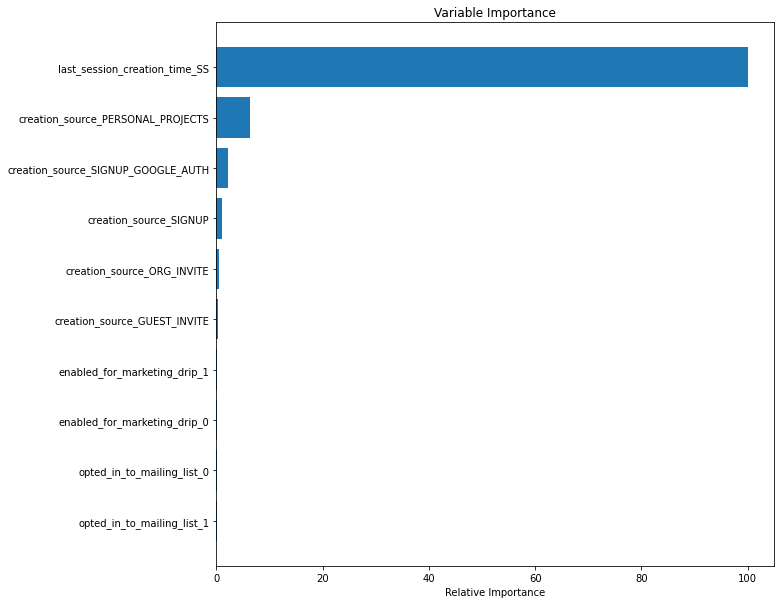

In [105]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
#print(pos.size)
#sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

f1 score was over 90% which was very great metric outcome. asd